In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

day = -1
round_no = 2

prc_df = pd.read_csv(rf"prices_round_{round_no}_day_{day}.csv", sep=';')
trades_df = pd.read_csv(rf"trades_round_{round_no}_day_{day}.csv", sep=';')

#### Basket composition

+ PICNIC_BASKET1 = 6*CROISSANTS + 3*JAMS + 1*DJEMBES
+ PICNIC_BASKET2 = 4*CROISSANTS + 2*JAMS

##### Position Limits
|PRODUCT       | LIMIT|
|--------------|------|
|  CROISSANTS  | 250  |
|        JAMS  | 350  |
|     DJEMBES  |  60  |
|PICNIC_BASKET1|  60  |
|PICNIC_BASKET2| 100  |


In [59]:
prc_df_croiss = prc_df[prc_df['product'] == "CROISSANTS"]
prc_df_jams = prc_df[prc_df['product'] == "JAMS"]
prc_df_djembes = prc_df[prc_df['product'] == "DJEMBES"]
prc_df_pb1 = prc_df[prc_df['product'] == "PICNIC_BASKET1"]
prc_df_pb2 = prc_df[prc_df['product'] == "PICNIC_BASKET2"]

In [60]:
price_pivot = prc_df.pivot(index='timestamp',
                           columns='product',
                           values='mid_price')


+ While this was our first prosperity/trading competition, we did look into previous years' GitHub in order to be best prepared for PROSPERITY3.
+ After looking at a similar version of this round in both PROSPERITY 1 & 2, I decided to spend a fair bit of time trying to work out a strategy comparable to the best few from last years.
+ I was actually able to build an algorithm which outperform them using a the principles of Beta CDF which calculates the required position in the basket and its synthetic components by mapping the divergence using the inverse CDF.
+ I will discuss in detail why I chose this strategy, to look at the visual representation and math behind it please look at our ROUND1 Squid strategy.
+ This strategy was originally made for the baskets before the competition started but I ended up using it in multiple rounds.

### Inter-Basket Arbitrage

+ After looking at the position limits I was almost certain that instead of looking at mispricings between the baskets and it's synthetics maybe we should be looking at the mispricing between the baskets.
$$
\
2\,\times\,\text{PICNIC\_BASKET1}
\;=\;
3\,\times\,\text{PICNIC\_BASKET2}
\;+\;
2\,\times\,\text{DJEMBES}
\
$$

$$
\
\Delta_{\text{basket}}
\;=\;
2\,\times\,\text{PICNIC\_BASKET1}
\;-\;
\bigl(
3\,\times\,\text{PICNIC\_BASKET2}
\;+\;
2\,\times\,\text{DJEMBES}
\bigr).
\
$$

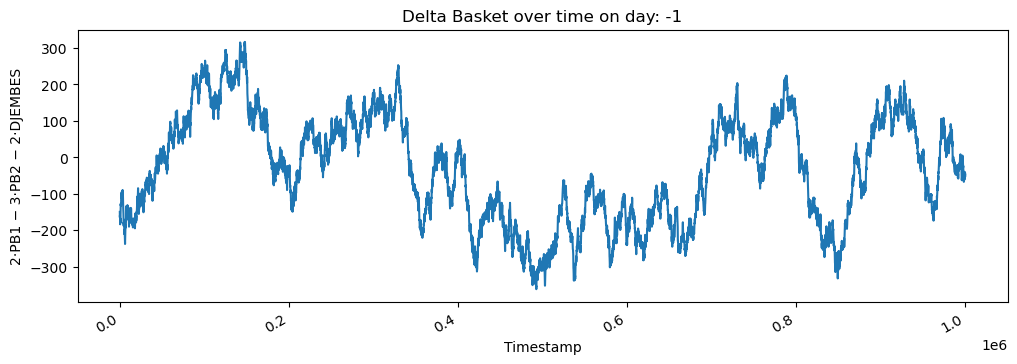

In [61]:
## PLOT Delta Basket

delta_basket = (
    2 * price_pivot['PICNIC_BASKET1']
  - 3 * price_pivot['PICNIC_BASKET2']
  - 2 * price_pivot['DJEMBES']
)

plt.figure(figsize=(12,4))
plt.plot(delta_basket.index, delta_basket.values)
plt.title(f"Delta Basket over time on day: {day}")
plt.xlabel("Timestamp")
plt.ylabel("2·PB1 − 3·PB2 − 2·DJEMBES")
plt.gcf().autofmt_xdate()  # nicely rotate dates
plt.show()

We define Delta Long basket and Delta short basket below

\begin{aligned}
\Delta_{\text{long}}
&=
2 \,\times\, \mathrm{PICNIC\_BASKET1}_{\mathrm{bid}}
\;-\;
3 \,\times\, \mathrm{PICNIC\_BASKET2}_{\mathrm{ask}}
\;-\;
2 \,\times\, \mathrm{DJEMBES}_{\mathrm{ask}},
\\[1ex]
\Delta_{\text{short}}
&=
3 \,\times\, \mathrm{PICNIC\_BASKET2}_{\mathrm{bid}}
\;+\;
2 \,\times\, \mathrm{DJEMBES}_{\mathrm{bid}}
\;-\;
2 \,\times\, \mathrm{PICNIC\_BASKET1}_{\mathrm{ask}}.
\end{aligned}


In [62]:
price_pivot_best_bid = prc_df.pivot(index='timestamp',
                           columns='product',
                           values='bid_price_1')
price_pivot_best_ask = prc_df.pivot(index='timestamp',
                           columns='product',
                           values='ask_price_1')
                                    

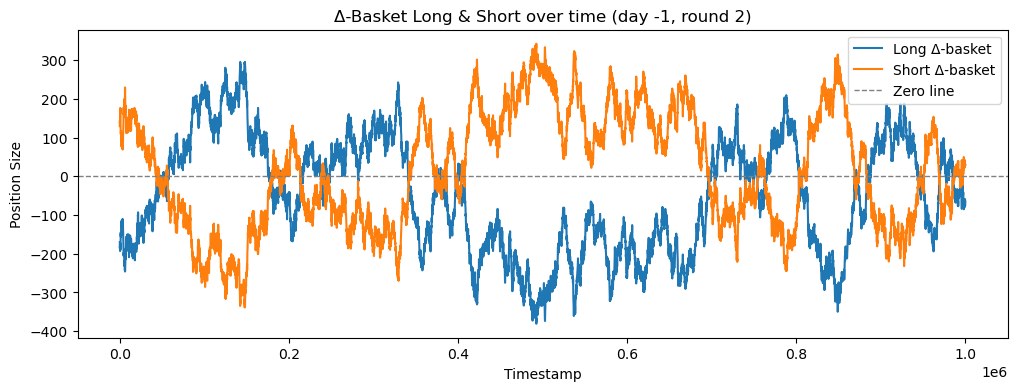

In [63]:
## PLOT Delta Basket Long and Delta Basket Short
delta_basket_long = (
    2 * price_pivot_best_bid['PICNIC_BASKET1']
  - 3 * price_pivot_best_ask['PICNIC_BASKET2']
  - 2 * price_pivot_best_ask['DJEMBES']
)

delta_basket_short = (
    3 * price_pivot_best_bid['PICNIC_BASKET2']
    + 2 * price_pivot_best_bid['DJEMBES']
  - 2 * price_pivot_best_ask['PICNIC_BASKET1']
)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(delta_basket_long.index,  delta_basket_long.values,  label='Long Δ-basket')
ax.plot(delta_basket_short.index, delta_basket_short.values, label='Short Δ-basket')

# horizontal zero-line at y=0
ax.axhline(0, color='gray', linestyle='--', linewidth=1, label='Zero line')

# labels, title, legend
ax.set_title(f"Δ-Basket Long & Short over time (day {day}, round {round_no})")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Position Size")
ax.legend()

plt.show()

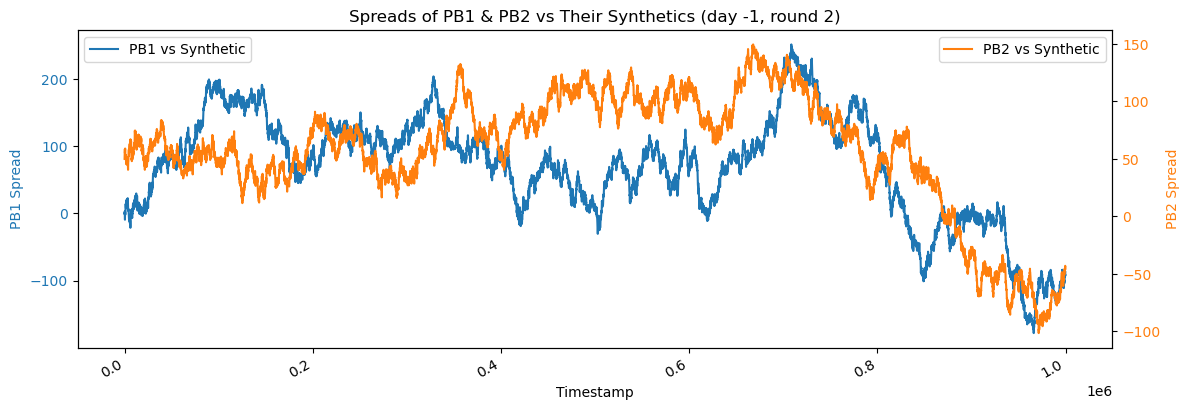

In [64]:
price_pivot = prc_df.pivot(index='timestamp', columns='product', values='mid_price')

# 3) Compute synthetics and spreads
syn_pb1 = 6*price_pivot['CROISSANTS'] + 3*price_pivot['JAMS'] + 1*price_pivot['DJEMBES']
syn_pb2 = 4*price_pivot['CROISSANTS'] + 2*price_pivot['JAMS']

spread_pb1 = (price_pivot['PICNIC_BASKET1'] - syn_pb1).dropna()
spread_pb2 = (price_pivot['PICNIC_BASKET2'] - syn_pb2).dropna()

# 4) Plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(12,4))

# PB1 spread on left axis
ax1.plot(spread_pb1.index, spread_pb1.values, label='PB1 vs Synthetic', color='tab:blue')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('PB1 Spread', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# PB2 spread on right axis
ax2 = ax1.twinx()
ax2.plot(spread_pb2.index, spread_pb2.values, label='PB2 vs Synthetic', color='tab:orange')
ax2.set_ylabel('PB2 Spread', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Tidy up
fig.autofmt_xdate()
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f"Spreads of PB1 & PB2 vs Their Synthetics (day {day}, round {round_no})")
plt.show()

+ We can observe that there is a stronger reversion when using the inter basket arbitrage as opposed to the Spread between either baskets and their synthetic components. (Day -1)
+ However this wasn't the case on all three days, and we observed there were days it would be more profitable to trade the spread between baskets and it's components. (Day 1)

## Explore PAIRS TRADING

In [65]:
!pip install statsmodels
import statsmodels
from statsmodels.tsa.stattools import coint

Defaulting to user installation because normal site-packages is not writeable


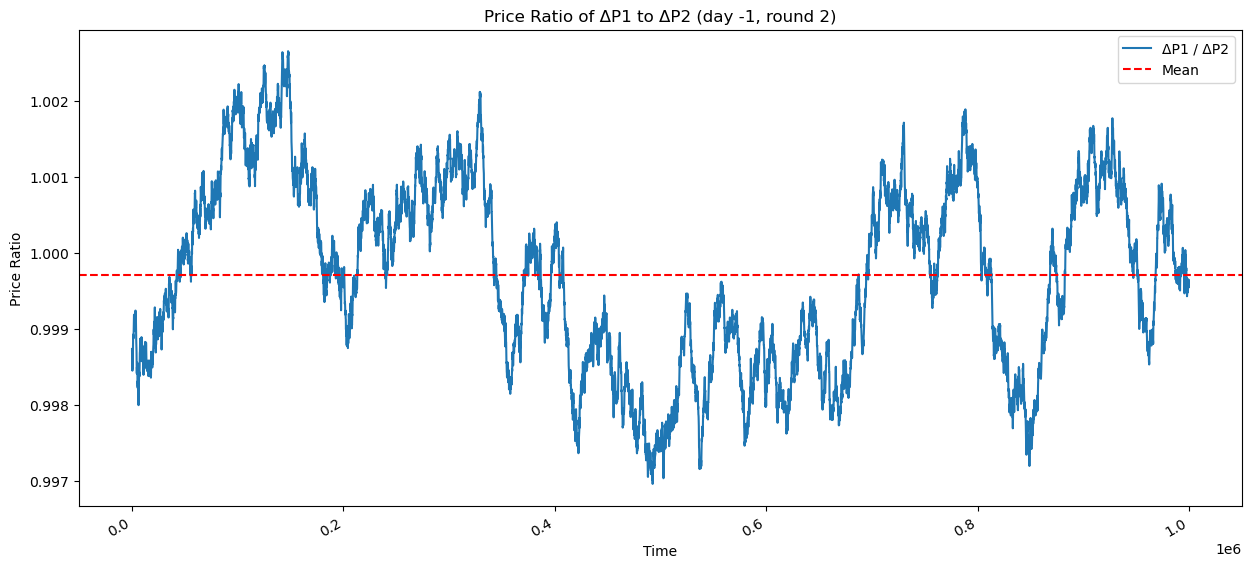

Engle–Granger cointegration test p-value: 0.1158


In [66]:
DELTA_P1 = 2 * price_pivot['PICNIC_BASKET1']
DELTA_P2 = 3 * price_pivot['PICNIC_BASKET2'] + 2 * price_pivot['DJEMBES']

ratio = DELTA_P1 / DELTA_P2
plt.figure(figsize=(15,7))
plt.plot(ratio.index, ratio.values, label='ΔP1 / ΔP2')
plt.axhline(ratio.mean(), color='red', linestyle='--', label='Mean')
plt.xlabel('Time')
plt.ylabel('Price Ratio')
plt.legend()
plt.title(f"Price Ratio of ΔP1 to ΔP2 (day {day}, round {round_no})")
plt.gcf().autofmt_xdate()
plt.show()

score, pvalue, _ = coint(DELTA_P1.dropna(), DELTA_P2.dropna())
print(f"Engle–Granger cointegration test p-value: {pvalue:.4f}")

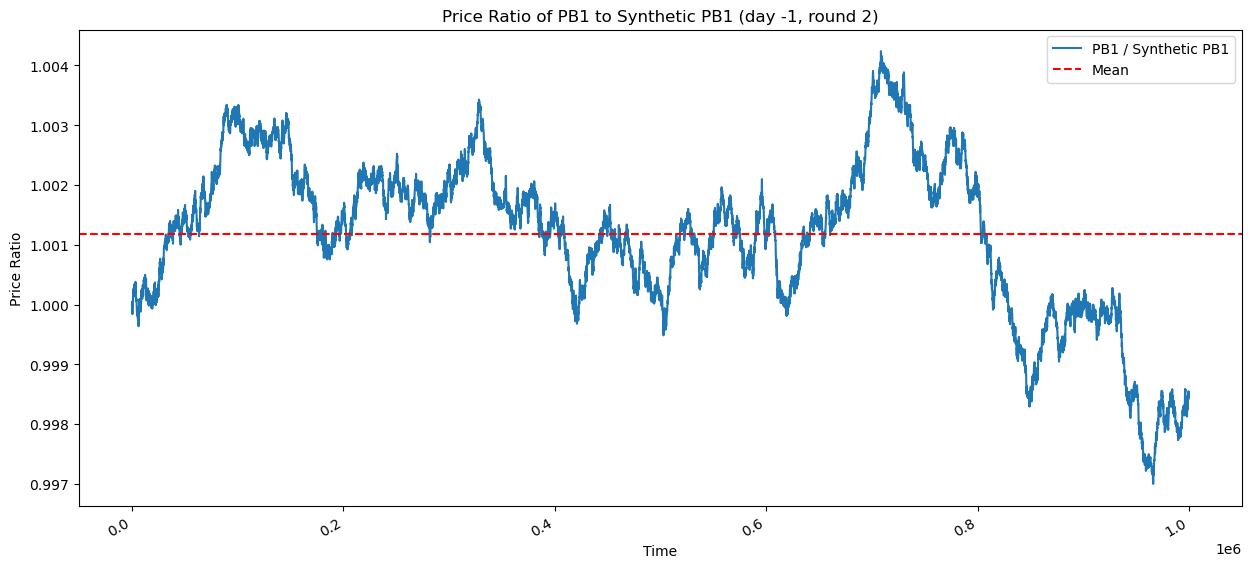

Engle–Granger cointegration test p-value: 0.6903


In [69]:
PB1 = price_pivot['PICNIC_BASKET1']
syn_pb1 = 6*price_pivot['CROISSANTS'] + 3*price_pivot['JAMS'] + 1*price_pivot['DJEMBES']

ratio = PB1 / syn_pb1
plt.figure(figsize=(15,7))
plt.plot(ratio.index, ratio.values, label='PB1 / Synthetic PB1')
plt.axhline(ratio.mean(), color='red', linestyle='--', label='Mean')
plt.xlabel('Time')
plt.ylabel('Price Ratio')
plt.legend()
plt.title(f"Price Ratio of PB1 to Synthetic PB1 (day {day}, round {round_no})")
plt.gcf().autofmt_xdate()
plt.show()

score, pvalue, _ = coint(PB1.dropna(), syn_pb1.dropna())
print(f"Engle–Granger cointegration test p-value: {pvalue:.4f}")

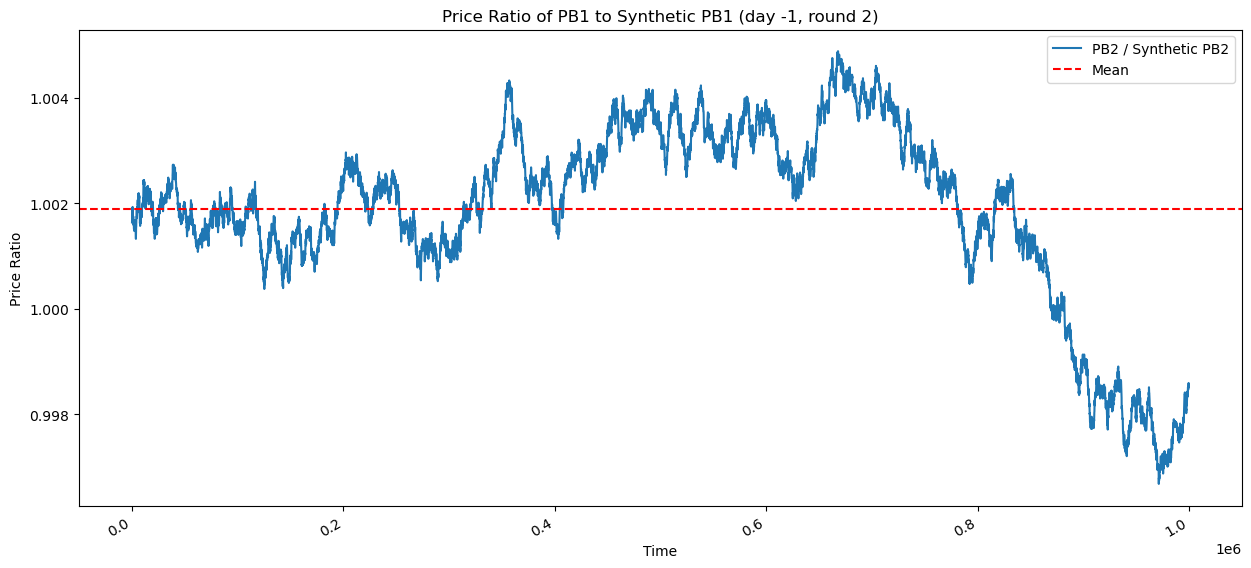

Engle–Granger cointegration test p-value: 0.8328


In [71]:
PB2 = price_pivot['PICNIC_BASKET2']
syn_pb2 = 4*price_pivot['CROISSANTS'] + 2*price_pivot['JAMS']

ratio = PB2 / syn_pb2
plt.figure(figsize=(15,7))
plt.plot(ratio.index, ratio.values, label='PB2 / Synthetic PB2')
plt.axhline(ratio.mean(), color='red', linestyle='--', label='Mean')
plt.xlabel('Time')
plt.ylabel('Price Ratio')
plt.legend()
plt.title(f"Price Ratio of PB1 to Synthetic PB1 (day {day}, round {round_no})")
plt.gcf().autofmt_xdate()
plt.show()

score, pvalue, _ = coint(PB2.dropna(), syn_pb2.dropna())
print(f"Engle–Granger cointegration test p-value: {pvalue:.4f}")

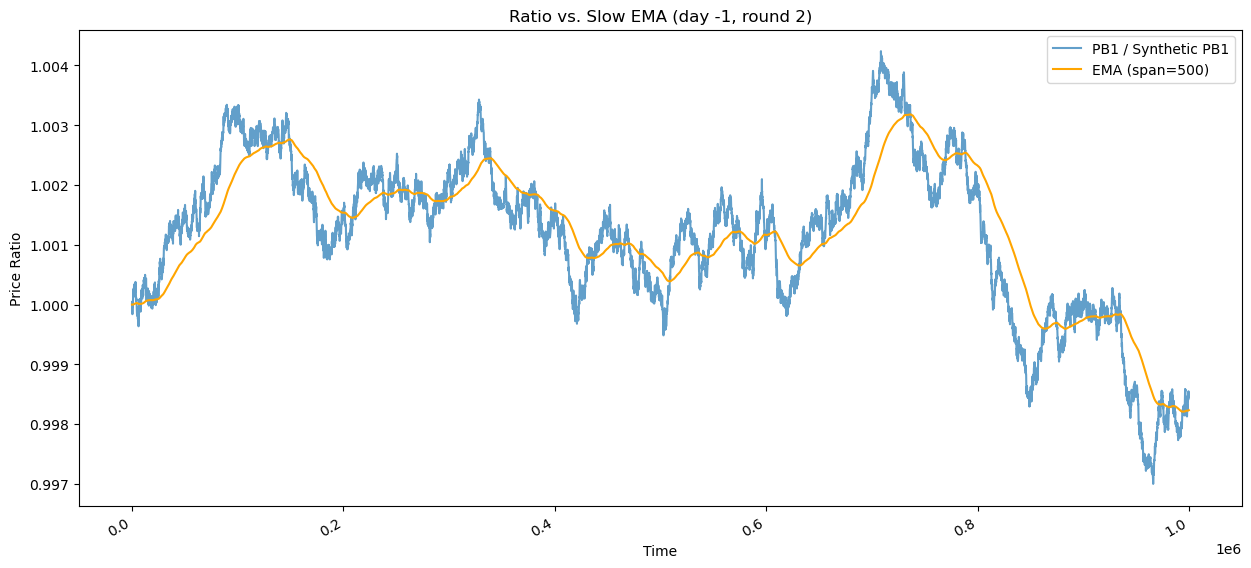

ADF p-value = 0.0003


In [76]:
from statsmodels.tsa.stattools import adfuller

PB1    = price_pivot['PICNIC_BASKET1']
syn_pb1 = 6*price_pivot['CROISSANTS'] \
        + 3*price_pivot['JAMS'] \
        + 1*price_pivot['DJEMBES']
ratio  = PB1 / syn_pb1

ema_span = 500
ema_ratio = ratio.ewm(span=ema_span, adjust=False).mean()

plt.figure(figsize=(15,7))
plt.plot(ratio.index,    ratio.values,    label='PB1 / Synthetic PB1', alpha=0.7)
plt.plot(ema_ratio.index, ema_ratio.values, label=f'EMA (span={ema_span})', color='orange')
plt.xlabel('Time')
plt.ylabel('Price Ratio')
plt.title(f"Ratio vs. Slow EMA (day {day}, round {round_no})")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


spread_ema = ratio - ema_ratio

# Test the spread for stationarity (ADF test)
adf_stat, adf_p, _, _, crit_vals, _ = adfuller(spread_ema.dropna())
print(f"ADF p-value = {adf_p:.4f}")


## Mean-Reversion Analysis of PB1 vs. Its Synthetic

### 1. Background  
We test whether **PICNIC_BASKET1** (PB1) reverts to its “fair value” given by the synthetic combination of its components:  
$$
\text{SyntheticPB1}_t
\;=\;
6\cdot\mathrm{CROISSANTS}_t
\;+\;
3\cdot\mathrm{JAMS}_t
\;+\;
1\cdot\mathrm{DJEMBES}_t
$$



### 2. Ratio & Dynamic Mean  

1. **Price Ratio**  
   $$
   \mathrm{ratio}_t
   \;=\;
   \frac{\mathrm{PB1}_t}{\text{SyntheticPB1}_t}
   $$

2. **Slow Exponential Moving Average (EMA)**  
   We compute a long‐span EMA of the ratio to allow a _time-varying_ mean:
   $$
   \mathrm{EMA}_t
   = \alpha\,\mathrm{ratio}_t \;+\;(1-\alpha)\,\mathrm{EMA}_{t-1},
   \quad
   \alpha = \frac{2}{\text{span}+1}
   $$
   or in pandas:
   ```python
   ema_ratio = ratio.ewm(span=500, adjust=False).mean()


#### 3. Interpretation

- **Null hypothesis:** $\mathrm{spread}_t$ has a unit root (non-stationary).  
- $p$-value = $0.0003 \ll 0.01$ $\implies$ reject the null at the 1\% level.  
- Since the ADF statistic is more negative than all critical values,  
  $$
  \mathrm{spread}_t \text{ is stationary around the EMA.}
  $$

#### 4. Conclusion

- Using a slow EMA gives a **dynamic fair value** instead of a static mean.  
- The ADF test confirms that deviations  
  $$
  \mathrm{ratio}_t - \mathrm{EMA}_t
  $$  
  are strongly **mean-reverting**.  
- You can trade on this signal by buying when  
  $$
  \mathrm{ratio}_t < \mathrm{EMA}_t - \delta
  $$  
  and selling when  
  $$
  \mathrm{ratio}_t > \mathrm{EMA}_t + \delta,
  $$  
  for some threshold $\delta$, capturing predictable reversion to the drifting equilibrium.  


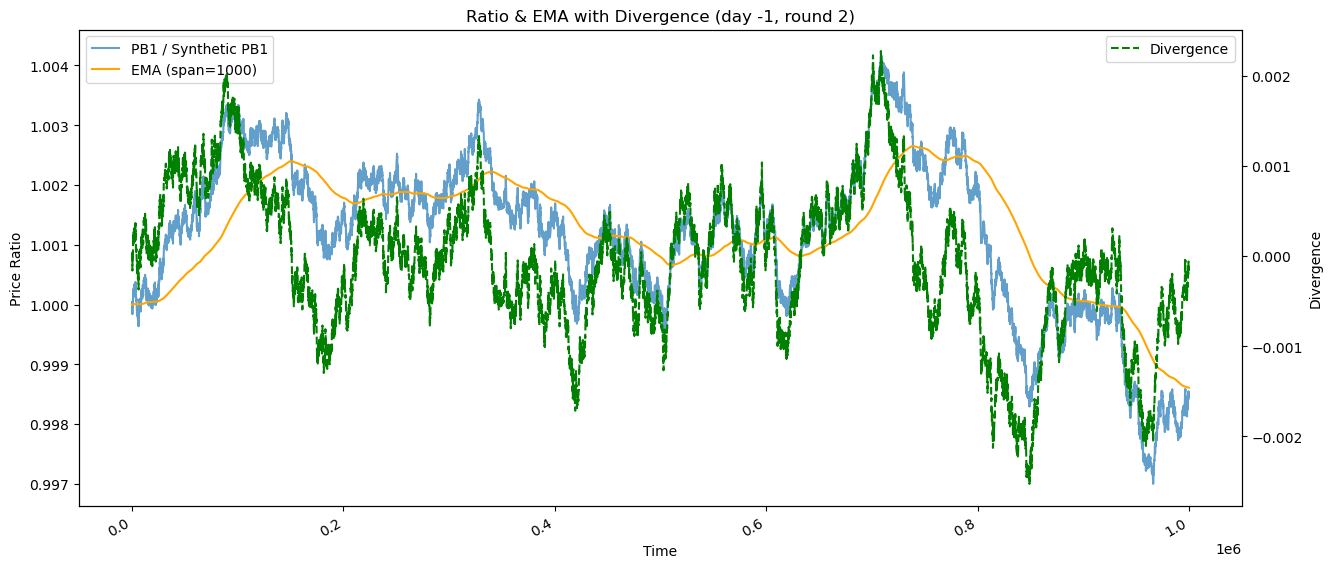

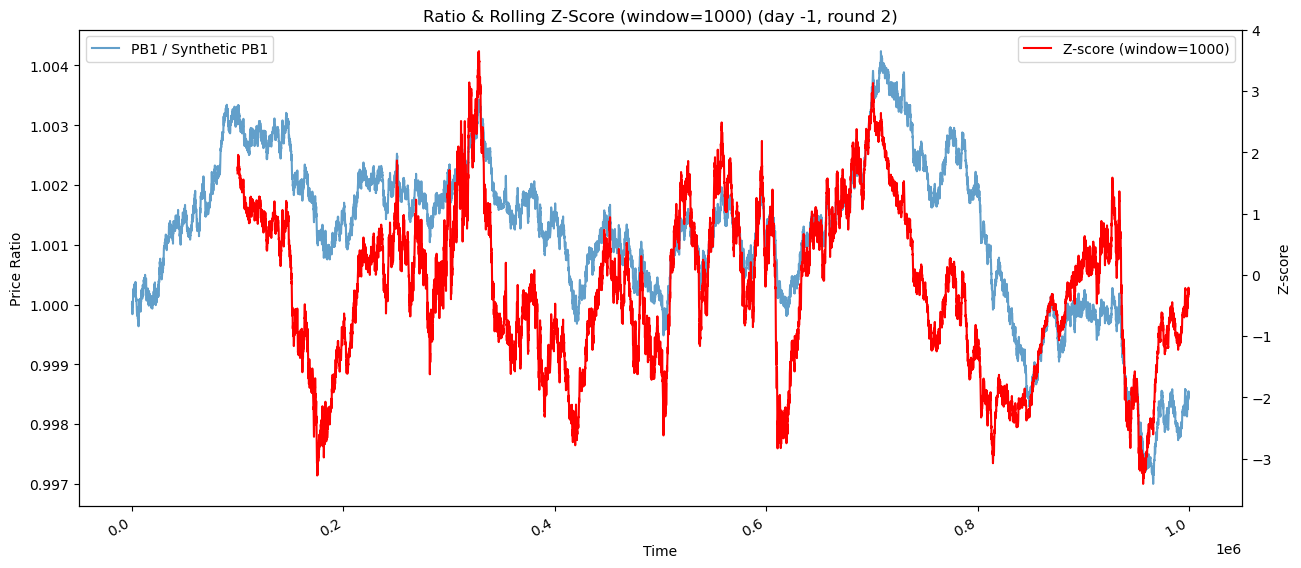

In [82]:
PB1      = price_pivot['PICNIC_BASKET1']
syn_pb1  = 6*price_pivot['CROISSANTS'] + 3*price_pivot['JAMS'] + 1*price_pivot['DJEMBES']

# Compute ratio and slow EMA
ratio     = PB1 / syn_pb1
ema_span  = 1000
ema_ratio = ratio.ewm(span=ema_span, adjust=False).mean()

# Compute divergence for Plot 1
divergence = ratio - ema_ratio

# --- Plot 1: Ratio vs EMA with divergence on secondary axis ---
fig, ax1 = plt.subplots(figsize=(15,7))
ax1.plot(ratio.index, ratio, label='PB1 / Synthetic PB1', alpha=0.7)
ax1.plot(ema_ratio.index, ema_ratio, label=f'EMA (span={ema_span})', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price Ratio')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(divergence.index, divergence, label='Divergence', color='green', linestyle='--')
ax2.set_ylabel('Divergence')
ax2.legend(loc='upper right')

plt.title(f"Ratio & EMA with Divergence (day {day}, round {round_no})")
fig.autofmt_xdate()
plt.show()

# --- Plot 2: Ratio & Rolling Z-Score on secondary axis ---
rolling_window = ema_span
rolling_mean   = ratio.rolling(window=rolling_window).mean()
rolling_std    = ratio.rolling(window=rolling_window).std()
zscore         = (ratio - rolling_mean) / rolling_std

fig, ax1 = plt.subplots(figsize=(15,7))
ax1.plot(ratio.index, ratio, label='PB1 / Synthetic PB1', alpha=0.7)
ax1.set_xlabel('Time')
ax1.set_ylabel('Price Ratio')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(zscore.index, zscore, label=f'Z-score (window={rolling_window})', color='red')
ax2.set_ylabel('Z-score')
ax2.legend(loc='upper right')

plt.title(f"Ratio & Rolling Z-Score (window={rolling_window}) (day {day}, round {round_no})")
fig.autofmt_xdate()
plt.show()

### Why not use Rolling Z-score

+ The reasoning can be divided in two parts, both leading us to reject the use of rolling z-score:
1) Confusing signals:
  > - By using a **z-score** we would simply be standardizing the difference between the **spread and EMA**.
  > - Intuitively if the spread becomes positive for a brief period, the z-score shoots up (as expected) but upon reversal a negative z-score can be observed simply by the spread converging to the EMA, which can give us a strong buy signal while we should simply get rid of the negative inventory and **NOT BUY** to get a positive inventory. This is hard to distinguish with Z-score.
  > - **WHY?** When we are using a rolling zscore and a **'HIGH-DIVERGENCE PERIOD'** can increase the **rolling mean**, thus on reversal we can get a **Negative Z-score** simply when converging back the the **EMA**.
2) Not an optimal addition to the algorithm:
  > - As we see, it is better to compute a **SLOW-EMA** to capture the divergence of the spread to its long run mean.
  > - To capture a z-score with a rolling window 500-1000 we would end up using most of our available TraderData memory if not all (2000 data points for 2 baskets in round 2).
  > - Doing this in round 2 did not seem appropriate as we might have needed the TraderData for the later rounds.

## Intuition behind mapping the position required to Inverse CDF as a function of divergence

+ I got a lot of questions after the round1 squid strategy writeup asking **WHY**?
+ I'll try my best to explain the thought process below:
 > - Let Spread_EMA = 0, and we would want to buy when the spread = -10.
>  - What would be the ideal thing to do? Buy everything when the spread is -10.
>  - We could theoretically run a grid search, find the **Best Offset** and call it a day.
>  - Let's say the grid search gave the optimal threshold as 10, so we should buy it all when the divergence between the spread and the spread_EMA is -10 and sell it all when the difference is 10.
>  - Instead of blindly following that let's think what that means
>  - Does it mean that there will be cases whent the divergence reaches -7 and reverts back? Will there be cases when the divergence reaches -15 and then revert back?
>  - There is a way we can further maximize our PnL and capture the small and large divergence much more optimally
>  - We can maybe get 2 different offsets, offset 1 = 5 and offset 2 = 10
>  - We start buying the basket when the spread divergence with its EMA exceeds 5 and buy it through 15.
>  - We can do it uniformaly where we buy $\frac{1}{10}$ of the required position at each increase in the divergence

## Introduce the Mapping below

We construct two Beta‐based cumulative distributions around our EMA backbone:

1. **Mirrored Beta** on $[a,b]$ with $a > b$ for the **buy** side  
2. **Standard Beta** on $[a,b]$ with $a < b$ for the **sell** side  

#### 1.1. Core formulas

- **Beta PDF** on $[0,1]$:  
  $$
    \mathrm{beta\_pdf}(u;\alpha,\beta)
    = \frac{u^{\alpha-1}(1 - u)^{\beta-1}}{B(\alpha,\beta)},\quad
    B(\alpha,\beta)=\frac{\Gamma(\alpha)\,\Gamma(\beta)}{\Gamma(\alpha+\beta)}
  $$
  Returns 0 if $u\not\in[0,1]$.

- **Ascending interval** $[a,b]$ ($a<b$):  
  - Map $x\mapsto u=\tfrac{x-a}{b-a}$.  
  - PDF in $x$-space:  
    $$
      \mathrm{pdf}_x(x)
      = \frac{\mathrm{beta\_pdf}\bigl(\tfrac{x-a}{b-a};\;\alpha_L,\alpha_R\bigr)}{b - a}.
    $$
  - CDF via the trapezoid rule:
    $$
      \mathrm{cdf}_x(x_i)
      = \sum_{k=1}^i \frac{\mathrm{pdf}_x(x_k) + \mathrm{pdf}_x(x_{k-1})}{2}\,\bigl(x_k - x_{k-1}\bigr).
    $$

- **Mirrored interval** $[a,b]$ ($a>b$):  
  - Map $x\mapsto u=\tfrac{a-x}{a-b}$ so $u$ runs $0\to1$ as $x$ runs $a\to b$.  
  - PDF$_x$ and CDF built identically, but on a **descending** grid, then interpolated “up” for queries.

#### 1.2. Dynamic EMA‐based endpoints

Let  
$$
  \mathrm{EMA}_t = \mathrm{EWMA}(\mathrm{mid\_price})_t,\quad
  \mathrm{offset}=12,\;\mathrm{buffer}=5.
$$  
We set:

- **Buy zone**:  
  $$
    a_{\rm buy} = \mathrm{EMA}_t - \mathrm{offset},\quad
    b_{\rm buy} = a_{\rm buy} - \mathrm{buffer}.
  $$
  Build a **mirrored** Beta on $[a_{\rm buy},\,b_{\rm buy}]$.

- **Sell zone**:  
  $$
    a_{\rm sell} = \mathrm{EMA}_t + \mathrm{offset},\quad
    b_{\rm sell} = a_{\rm sell} + \mathrm{buffer}.
  $$
  Build an **ascending** Beta on $[a_{\rm sell},\,b_{\rm sell}]$.

In [83]:
import math
import numpy as np
import matplotlib.pyplot as plt

def beta_pdf(u, alpha, beta):
    """
    Returns the value of the Beta(alpha,beta) PDF at u, for 0<=u<=1.
    Outside [0,1], returns 0.
    """
    if u < 0.0 or u > 1.0:
        return 0.0

    # Beta function in the denominator
    beta_func = math.gamma(alpha)*math.gamma(beta)/math.gamma(alpha + beta)

    # Numerator: u^(alpha-1) * (1-u)^(beta-1)
    return (u**(alpha - 1) * (1.0 - u)**(beta - 1)) / beta_func


### Change the parameters (alphaL & alphaR) to watch how it affects the distribution

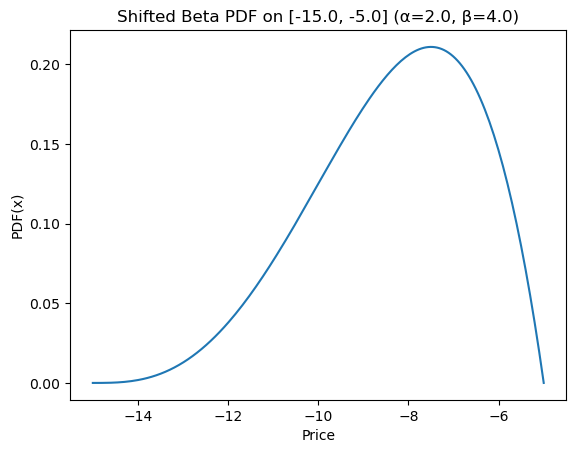

In [87]:
alphaL = 2.0   # shape for left tail
alphaR = 4.0   # shape for right tail
a      = 0 - 5.0      # left endpoint
b      = 0 - 10.0 - 5.0  # right endpoint of mirrored interval

# Make a grid of x-values
x_vals = np.linspace(a, b, 200)

# Convert each x to u in [0,1]
u_vals = (a - x_vals) / (a - b)

# Compute the Beta PDF on [a,b] manually
pdf_u = np.array([beta_pdf(u, alphaL, alphaR) for u in u_vals])

# Scale for [a,b]: pdf_x = pdf_u / |b-a|
pdf_x = pdf_u / abs(b - a)

# Plot
plt.plot(x_vals, pdf_x)
plt.title(f"Shifted Beta PDF on [{b:.1f}, {a:.1f}] (α={alphaL}, β={alphaR})")
plt.xlabel("Price")
plt.ylabel("PDF(x)")
plt.show()

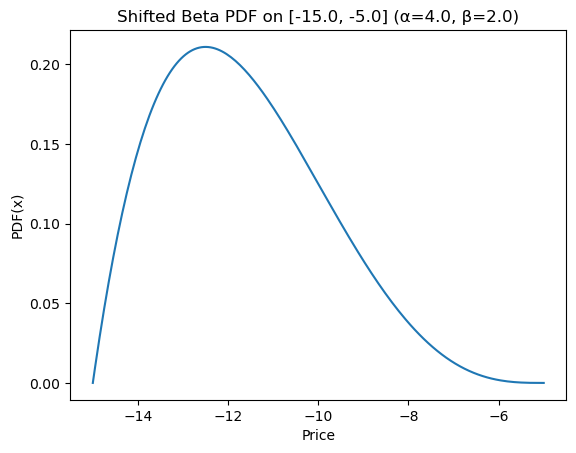

In [86]:
alphaL = 4.0   # shape for left tail
alphaR = 2.0   # shape for right tail
a      = 0 - 5.0      # left endpoint
b      = 0 - 10.0 - 5.0  # right endpoint of mirrored interval

# Make a grid of x-values
x_vals = np.linspace(a, b, 200)

# Convert each x to u in [0,1]
u_vals = (a - x_vals) / (a - b)

# Compute the Beta PDF on [a,b] manually
pdf_u = np.array([beta_pdf(u, alphaL, alphaR) for u in u_vals])

# Scale for [a,b]: pdf_x = pdf_u / |b-a|
pdf_x = pdf_u / abs(b - a)

# Plot
plt.plot(x_vals, pdf_x)
plt.title(f"Shifted Beta PDF on [{b:.1f}, {a:.1f}] (α={alphaL}, β={alphaR})")
plt.xlabel("Price")
plt.ylabel("PDF(x)")
plt.show()

## Observe the difference between the two graphs

+ Graph1: required position is calculated using alphal=2, alphaR=4) simply shows that we buy earlier as we expect the divergence to not exceed 10, while the Graph2: (alphal=4, alphaR=2) we buy more when the divergence reaches -13 as we expect a larger divergence between the spread and the spread EMA
+ Doing this allows us to capture a whole range of different divergences and we can maximize the PnL using a grid search by finding the optimal Offset1, Offset2, alphaL, and alphaR.

###  From CDF → Position

Define scale parameters  
$\mathrm{scale}_{\rm buy} = Q_{\max},\;\mathrm{scale}_{\rm sell} = Q_{\max}$  
(where $Q_{\max}$ is your maximum allowable volume, e.g. 60).

- **Buy‐side inventory** at price $p$:  
  $$
    \mathrm{buy\_pos}(p)
    = \mathrm{scale}_{\rm buy}\;\times\;\mathrm{cdf}_{\rm buy}(p),
  $$
  so that
  - $p = b_{\rm buy}$ (deep) ⇒ $\mathrm{cdf}_{\rm buy}=1$ ⇒ full long  
  - $p = a_{\rm buy}$ (shallow) ⇒ $\mathrm{cdf}_{\rm buy}=0$ ⇒ no long

- **Sell‐side inventory** at price $p$:  
  $$
    \mathrm{sell\_pos}(p)
    = -\,\mathrm{scale}_{\rm sell}\;\times\;\mathrm{cdf}_{\rm sell}(p),
  $$
  so that
  - $p = a_{\rm sell}$ (shallow) ⇒ $\mathrm{cdf}_{\rm sell}=0$ ⇒ no short  
  - $p = b_{\rm sell}$ (deep) ⇒ $\mathrm{cdf}_{\rm sell}=1$ ⇒ full short

- **Net target position**:  
  $$
    \mathrm{pos}_{\rm net}(p)
    = \mathrm{buy\_pos}(p) + \mathrm{sell\_pos}(p).
  $$


In [89]:
import math
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
#                  1) MIRRORED BETA ON [a..b] WHEN a > b (BUY SIDE)
###############################################################################
def beta_pdf(u, alpha, beta):
    """
    Returns Beta(alpha,beta) PDF at u in [0,1].
    Outside [0,1], returns 0.
    """
    if u < 0.0 or u > 1.0:
        return 0.0
    beta_func = math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)
    return (u**(alpha - 1) * (1.0 - u)**(beta - 1)) / beta_func

def build_mirrored_beta_distribution(a, b, alphaL, alphaR, steps=100):
    """
    Builds a Beta-based distribution on [a..b] when a > b (descending).
    Returns x_vals_desc, pdf_desc, cdf_desc, cdf_at(x).
    """
    if not (a > b):
        raise ValueError("For mirrored distribution, expect a > b.")
    x_vals_desc = np.linspace(a, b, steps)
    def x_to_u(x):
        return (a - x) / (a - b)
    pdf_u_desc = np.array([beta_pdf(x_to_u(x), alphaL, alphaR) for x in x_vals_desc])
    pdf_x_desc = pdf_u_desc / abs(b - a)
    cdf_desc = np.zeros_like(pdf_x_desc)
    for i in range(1, steps):
        dx = x_vals_desc[i] - x_vals_desc[i - 1]
        area = 0.5 * (pdf_x_desc[i] + pdf_x_desc[i - 1]) * abs(dx)
        cdf_desc[i] = cdf_desc[i - 1] + area
    def cdf_at(x):
        if x >= a:
            return 0.0
        if x <= b:
            return 1.0
        x_asc = x_vals_desc[::-1]
        cdf_asc = cdf_desc[::-1]
        return np.interp(x, x_asc, cdf_asc)
    return x_vals_desc, pdf_x_desc, cdf_desc, cdf_at

###############################################################################
#      2) ASCENDING BETA ON [a..b] WHEN a < b (SELL SIDE)
###############################################################################
def build_ascending_beta_distribution(a, b, alphaL, alphaR, steps=100):
    """
    Standard Beta distribution on [a..b], a<b, ascending array.
    Returns x_vals, pdf_x, cdf_x, cdf_at(x).
    """
    if not (a < b):
        raise ValueError("For ascending distribution, expect a < b.")
    x_vals = np.linspace(a, b, steps)
    def x_to_u(x):
        return (x - a) / (b - a)
    pdf_u = np.array([beta_pdf(x_to_u(xx), alphaL, alphaR) for xx in x_vals])
    pdf_x = pdf_u / (b - a)
    cdf_x = np.zeros_like(pdf_x)
    for i in range(1, steps):
        dx = x_vals[i] - x_vals[i - 1]
        area = 0.5 * (pdf_x[i] + pdf_x[i - 1]) * dx
        cdf_x[i] = cdf_x[i - 1] + area
    def cdf_at(x):
        if x <= a:
            return 0.0
        if x >= b:
            return 1.0
        return np.interp(x, x_vals, cdf_x)
    return x_vals, pdf_x, cdf_x, cdf_at

###############################################################################
#            3) BUILD THE "BUY" SIDE (MIRRORED) on [-12, -17]
###############################################################################
alphaL_buy, alphaR_buy = 2.0, 2.0
buy_a, buy_b = -12, -17  # a > b
x_vals_buy, pdf_buy, cdf_buy, cdf_buy_at = build_mirrored_beta_distribution(
    buy_a, buy_b, alphaL_buy, alphaR_buy, steps=100
)

def buy_position(ask_price, scale=50):
    """
    Positive inventory for buying:
      ask=200 => cdf_at(200)=1 => buy=+60
      ask=330 => cdf_at(330)=0 => buy=0
    => buy_position = scale * cdf_at(ask_price)
    """
    return scale * cdf_buy_at(ask_price)

###############################################################################
#           4) BUILD THE "SELL" SIDE (ASCENDING) on [12, 17]
###############################################################################
alphaL_sell, alphaR_sell = 2.0, 2.0
sell_a, sell_b = 12, 17  # a < b
x_vals_sell, pdf_sell, cdf_sell, cdf_sell_at = build_ascending_beta_distribution(
    sell_a, sell_b, alphaL_sell, alphaR_sell, steps=100
)

def sell_position(bid_price, scale=50):
    """
    Negative inventory for selling:
      bid=390 => cdf_at(390)=0 => sell=0
      bid=500 => cdf_at(500)=1 => sell=-60
    => sell_position = -scale * cdf_at(bid_price)
    """
    return -scale * cdf_sell_at(bid_price)



## Try changing the ask & bid to see how our desired position changes (Price = 0)

ask=15, bid=13
buy side = 0.00, sell side = -5.20, total=-5.20


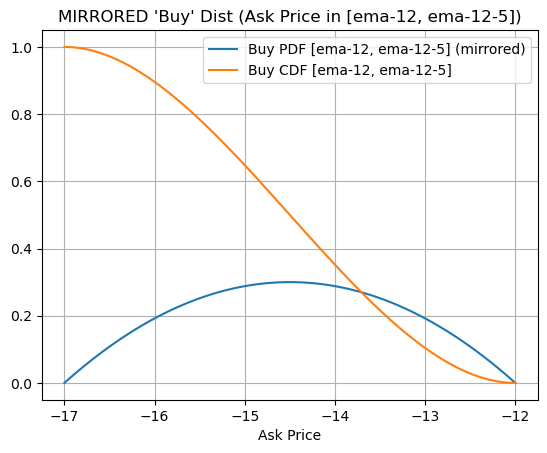

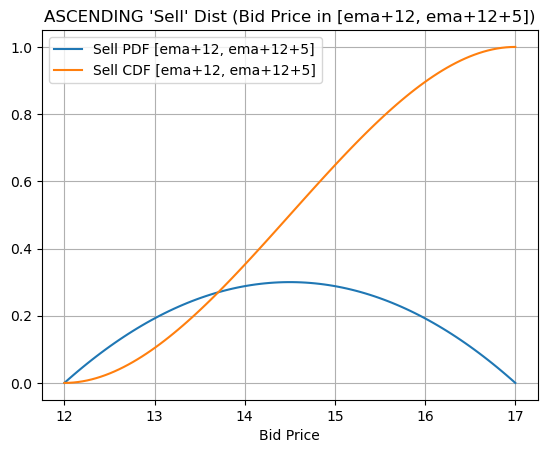

In [90]:
###############################################################################
#                 5) QUICK TEST
###############################################################################
test_ask = 15
test_bid = 13
inv_buy_side = buy_position(test_ask, scale=50)
inv_sell_side = sell_position(test_bid, scale=50)
inv_total = inv_buy_side + inv_sell_side
print(f"ask={test_ask}, bid={test_bid}")
print(f"buy side = {inv_buy_side:.2f}, sell side = {inv_sell_side:.2f}, total={inv_total:.2f}")

###############################################################################
#                6) PLOTTING
###############################################################################
# Plot buy distribution
plt.figure()
plt.plot(x_vals_buy, pdf_buy, label="Buy PDF [ema-12, ema-12-5] (mirrored)")
plt.plot(x_vals_buy, cdf_buy, label="Buy CDF [ema-12, ema-12-5]")
plt.title("MIRRORED 'Buy' Dist (Ask Price in [ema-12, ema-12-5])")
plt.xlabel("Ask Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot sell distribution
plt.figure()
plt.plot(x_vals_sell, pdf_sell, label="Sell PDF [ema+12, ema+12+5]")
plt.plot(x_vals_sell, cdf_sell, label="Sell CDF [ema+12, ema+12+5]")
plt.title("ASCENDING 'Sell' Dist (Bid Price in [ema+12, ema+12+5])")
plt.xlabel("Bid Price")
plt.legend()
plt.grid(True)
plt.show()


## Why not Trade Croissant and Jams?

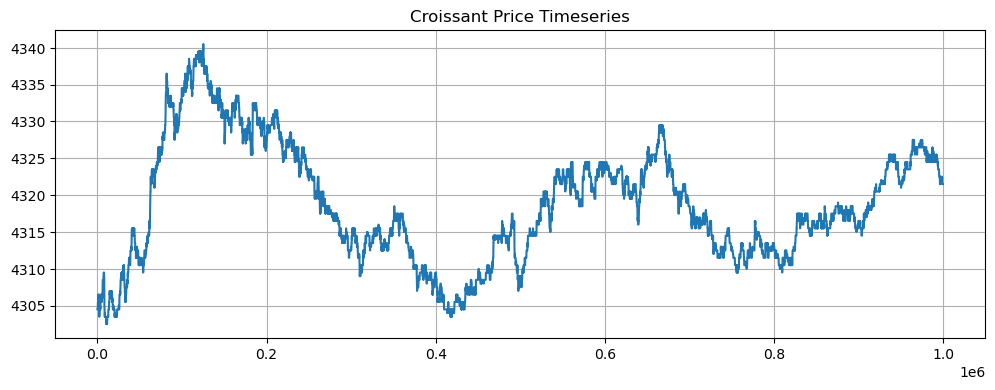

In [93]:
prc_df_croiss
prc_df_jams
prc_df_djembes

plt.figure(figsize=(12,4))
plt.plot(prc_df_croiss['timestamp'], prc_df_croiss['mid_price'])
plt.title("Croissant Price Timeseries")
plt.grid(True)
plt.show()

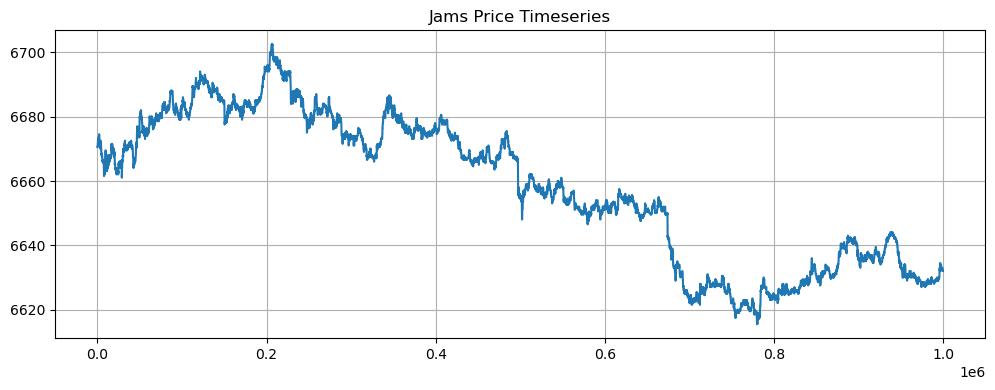

In [92]:
plt.figure(figsize=(12,4))
plt.plot(prc_df_jams['timestamp'], prc_df_jams['mid_price'])
plt.title("Jams Price Timeseries")
plt.grid(True)
plt.show()

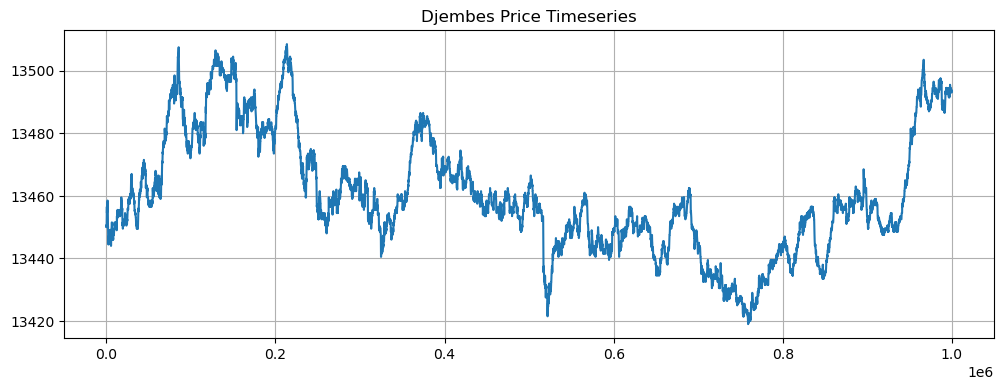

In [94]:
plt.figure(figsize=(12,4))
plt.plot(prc_df_djembes['timestamp'], prc_df_djembes['mid_price'])
plt.title("Djembes Price Timeseries")
plt.grid(True)
plt.show()

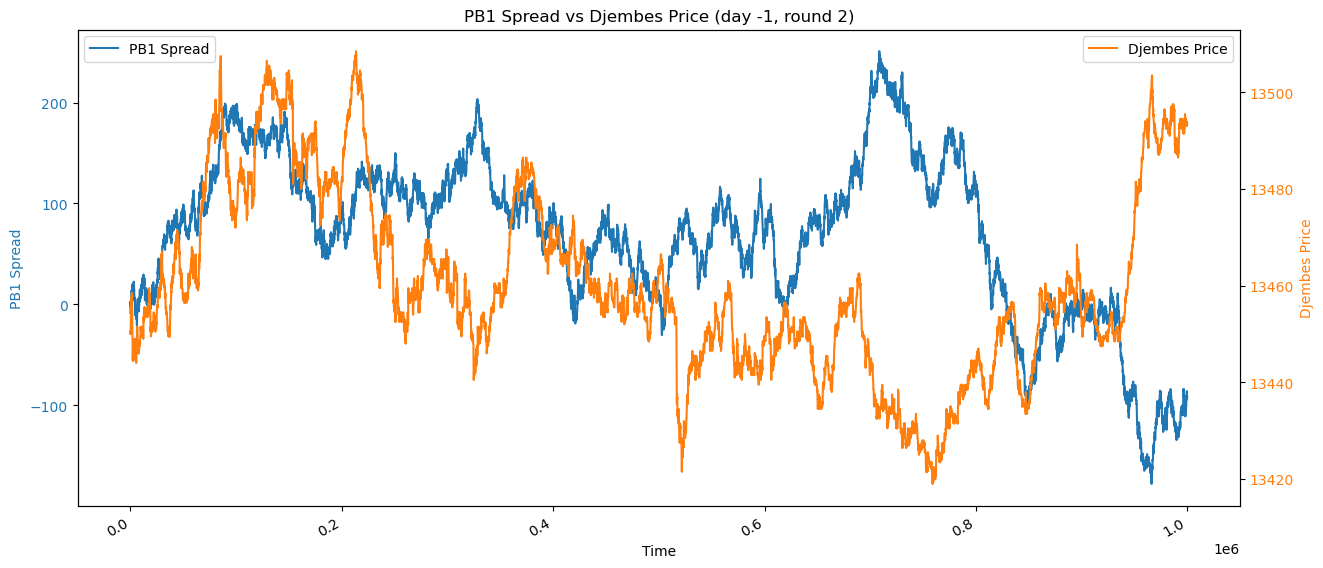

In [98]:
price_pivot = prc_df.pivot(index='timestamp', columns='product', values='mid_price')


syn_pb1 = 6 * price_pivot['CROISSANTS'] + 3 * price_pivot['JAMS'] + 1 * price_pivot['DJEMBES']
spread_pb1 = (price_pivot['PICNIC_BASKET1'] - syn_pb1).dropna()


djembes_price = price_pivot['DJEMBES'].dropna()


fig, ax1 = plt.subplots(figsize=(15,7))


ax1.plot(spread_pb1.index, spread_pb1, label='PB1 Spread', color='tab:blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('PB1 Spread', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')


ax2 = ax1.twinx()
ax2.plot(djembes_price.index, djembes_price, label='Djembes Price', color='tab:orange')
ax2.set_ylabel('Djembes Price', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.legend(loc='upper right')

# Tidy up and show
fig.autofmt_xdate()
plt.title(f"PB1 Spread vs Djembes Price (day {day}, round {round_no})")
plt.show()

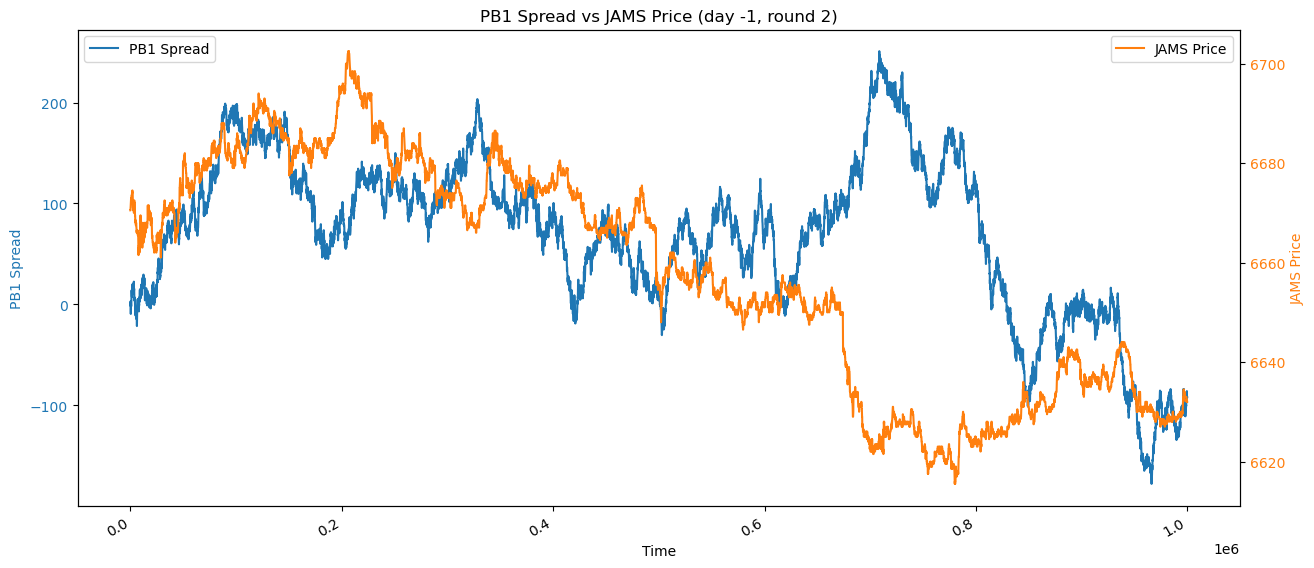

In [97]:
price_pivot = prc_df.pivot(index='timestamp', columns='product', values='mid_price')


syn_pb1 = 6 * price_pivot['CROISSANTS'] + 3 * price_pivot['JAMS'] + 1 * price_pivot['DJEMBES']
spread_pb1 = (price_pivot['PICNIC_BASKET1'] - syn_pb1).dropna()


djembes_price = price_pivot['JAMS'].dropna()


fig, ax1 = plt.subplots(figsize=(15,7))


ax1.plot(spread_pb1.index, spread_pb1, label='PB1 Spread', color='tab:blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('PB1 Spread', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Djembes Price on right axis
ax2 = ax1.twinx()
ax2.plot(djembes_price.index, djembes_price, label='JAMS Price', color='tab:orange')
ax2.set_ylabel('JAMS Price', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.legend(loc='upper right')

# Tidy up and show
fig.autofmt_xdate()
plt.title(f"PB1 Spread vs JAMS Price (day {day}, round {round_no})")
plt.show()

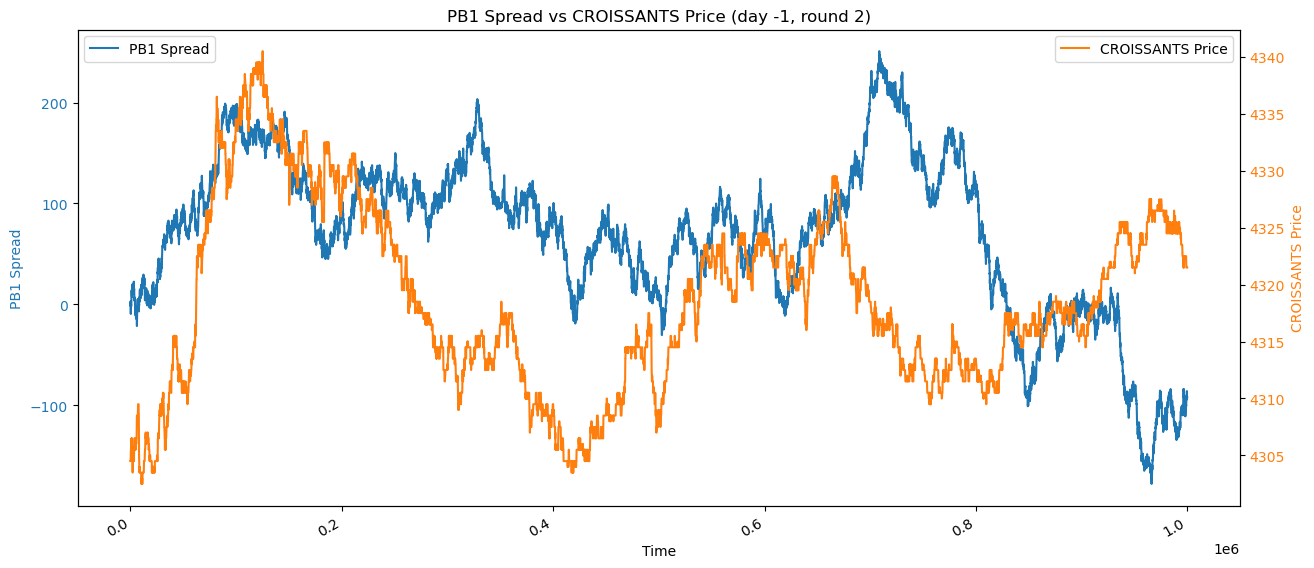

In [100]:
price_pivot = prc_df.pivot(index='timestamp', columns='product', values='mid_price')


syn_pb1 = 6 * price_pivot['CROISSANTS'] + 3 * price_pivot['JAMS'] + 1 * price_pivot['DJEMBES']
spread_pb1 = (price_pivot['PICNIC_BASKET1'] - syn_pb1).dropna()


djembes_price = price_pivot['CROISSANTS'].dropna()


fig, ax1 = plt.subplots(figsize=(15,7))


ax1.plot(spread_pb1.index, spread_pb1, label='PB1 Spread', color='tab:blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('PB1 Spread', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Djembes Price on right axis
ax2 = ax1.twinx()
ax2.plot(djembes_price.index, djembes_price, label='CROISSANTS Price', color='tab:orange')
ax2.set_ylabel('CROISSANTS Price', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.legend(loc='upper right')

# Tidy up and show
fig.autofmt_xdate()
plt.title(f"PB1 Spread vs CROISSANTS Price (day {day}, round {round_no})")
plt.show()

### Rationale for only using Djembes to Hedge

+ Our original hypothesis was that we were going to conduct an inter basket arbitrage
+ We ended up not moving forward as it was more profitable to buy the basket 1 spread and sell basket 2 spread at different and more optimal time to capture the **mispricings**.
+ We proved both spreads divergence to be stationary to a slow moving EMA above using **ADF test**.
+ When plotting the spreads along with the price of each components we observed a better **'Mirrored-movement' of the spread between PB1 and synthetic with Djembes over Croissants and Jams**.
+ Croissants and Jams follow a much more linear movements, which we decided to stay away from.
+ Getting it wrong was not worth it, as we had a very **high position** limits for thoses products, and the sudden movements could lead to a high loss.
+ Also at most instances we observed the **BASKET 1 and BASKET 2** positions to be offsetting the risk from **CROISSANTS and JAMS**. (**If we are long 60 Basket 1 and short 90 Basket 2 our positions for CROISSANTS AND JAMS are 0**).
+ We decided to hedge **basket 1** with only **DJEMBES**